In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack 
using Plots
using OrdinaryDiffEq

In [3]:
t₀                     = 0.6
solver_tolerance       = 1e-8
solver                 = OrdinaryDiffEq.BS5();

In [4]:
rot_double_gyre = @velo_from_stream Ψ_rot_dgyre begin
    st          = heaviside(t)*heaviside(1-t)*t^2*(3-2*t) + heaviside(t-1)
    heaviside(x)= 0.5*(sign(x) + 1)
    Ψ_P         = sin(2π*x)*sin(π*y)
    Ψ_F         = sin(π*x)*sin(2π*y)
    Ψ_rot_dgyre = (1-st) * Ψ_P + st * Ψ_F
end
T(x,p) = flow(rot_double_gyre, x, [0.0, t₀ + p],
    tolerance = solver_tolerance, solver = solver)[end];

In [5]:
T₀(x)    = T(x,0)
dotT₀(x) = rot_double_gyre(T₀(x),nothing,t₀)

dotT₀ (generic function with 1 method)

In [6]:
DT₀(x)   = linearized_flow_autodiff(T₀, x)
CG(x)    = dott(inv(DT₀(x)))
A₀(x)    = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
Adot(x)  = linear_response_tensor(T₀,dotT₀, x, 0)

Adot (generic function with 1 method)

In [7]:
n = 1000
values_A₀ = Array{Float64, 2}(undef,n, n)
values_CG = Array{Float64, 2}(undef,n, n)
values_Adot = Array{Float64, 2}(undef,n, n)
i = 1
for x in range(0,1,length=n)
    j = 1
    for y in range(0,1,length=n)
        values_A₀[i,j] = Tensors.tr(A₀([x, y]))
        values_CG[i,j] = Tensors.tr(CG([x, y]))
        values_Adot[i,j] = Tensors.tr(Adot([x, y]))
        j += 1
    end
    i +=1
end

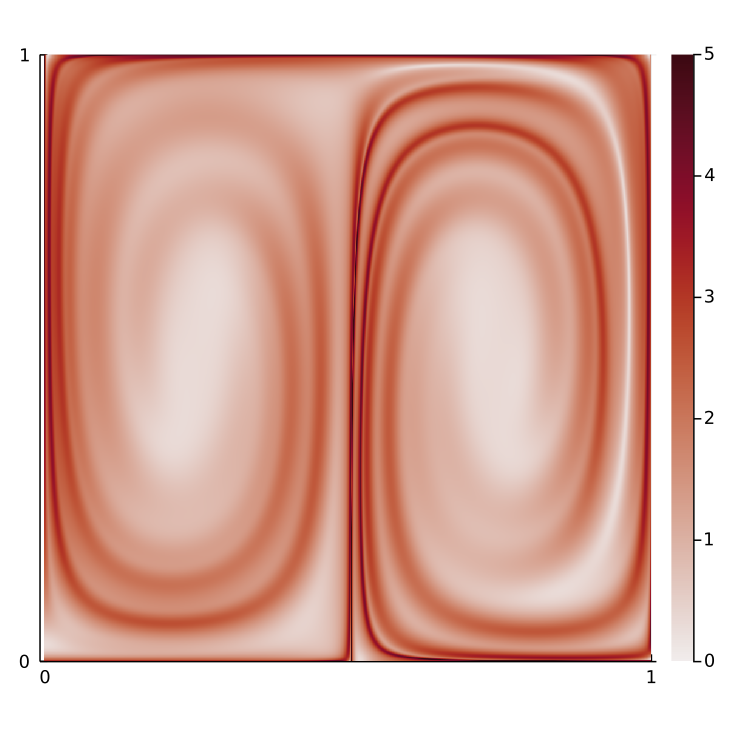

In [8]:
Plots.heatmap(range(0,1,length=n),range(0,1,length=n), log.(10,values_A₀'),
    color=:amp,clims=(0,5),xticks=0:1:1,yticks=0:1:1,aspectratio=:equal,
     size=(500,500),fmt=:png,dpi=150)

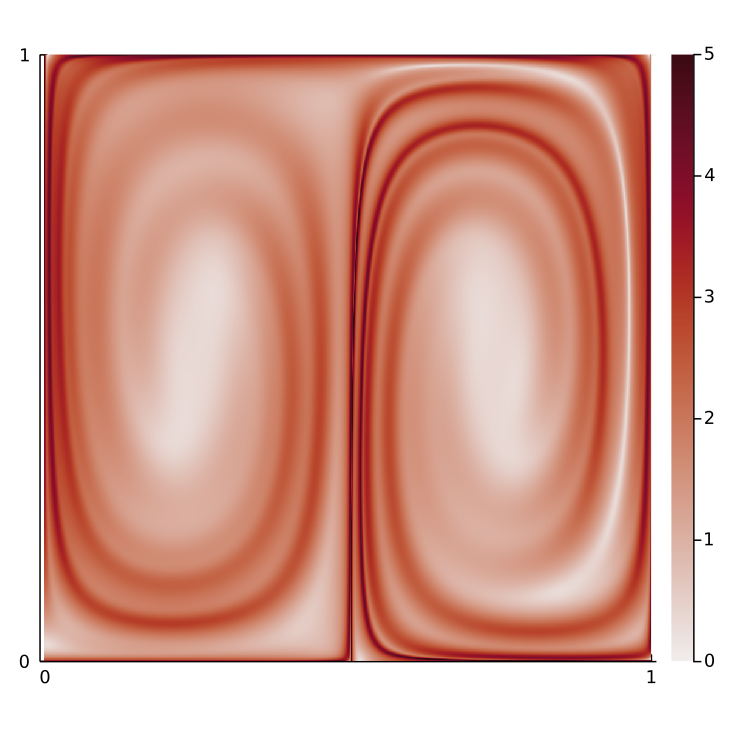

In [9]:
Plots.heatmap(range(0,1,length=n),range(0,1,length=n), log.(10,values_CG'),
    color=:amp,clims=(0,5),xticks=0:1:1,yticks=0:1:1,aspectratio=:equal,
     size=(500,500),fmt=:png,dpi=150)

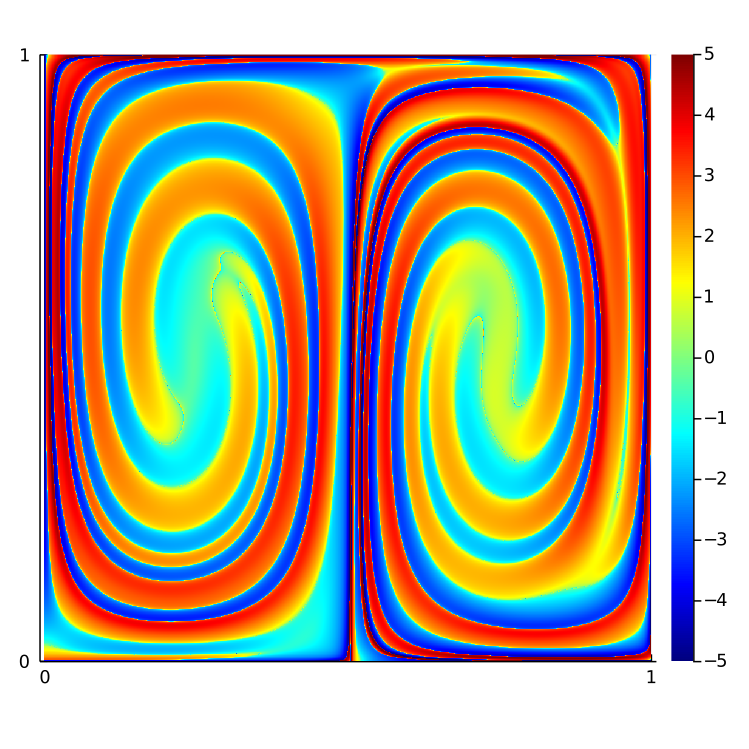

In [11]:
Plots.heatmap(range(0,1,length=n),range(0,1,length=n),sign.(values_Adot').*log.(10,abs.(values_Adot')),
    color=:balance,clims=(-5,5),xticks=0:1:1,yticks=0:1:1,aspectratio=:equal,fill=true,
     size=(500,500),fmt=:png,dpi=150)